# Homework #1

1. create a dataloader to load the galaxy10 dataset
2. build a classifier with a fully connceted neural network 
3. write a function to compute the classification accuracy of the network prediction
3. write a training loop and train the model
4. save the loss and accuracy for both the training dataset and the validation dataset after every epoch
5. plot the loss and accuracy
6. save the trained model and model source code (in a .py file)
7. email the trained model to jonathan.shlomi@weizmann.ac.il

In [5]:
path_to_training_data = 'C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/train'
path_to_validation_data = 'C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/validation/'

### The galaxy10 dataset

in this homework you will build a classifier for the galaxy10 dataset (https://astronn.readthedocs.io/en/latest/galaxy10.html)

but its a "special" version of the dataset created for this homework. The images have been converted to grayscale, and saved as png files in two directories, "train" and "validation". There is a seperate test dataset in a secret location, you will train a model, submit it, and we will evaluate it on the test dataset

you can submit the model once you have over 65% accuracy on the validation dataset. 


### DataLoader:

In [6]:
#first we get a list of the files in the directory

import glob
#glob gives you a list of file paths to the images
filelist = glob.glob(path_to_training_data+'/*.png')

#lets print the first 10 entries:
filelist[:10]

['C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/train\\class0_1023.png',
 'C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/train\\class0_1039.png',
 'C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/train\\class0_1043.png',
 'C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/train\\class0_1048.png',
 'C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/train\\class0_1051.png',
 'C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/train\\class0_1058.png',
 'C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/train\\class0_1065.png',
 'C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/train\\class0_1068.png',
 'C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/train\\class0_1073.png',
 'C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/train\\class0_1074.png']

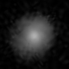

In [7]:
#to load a single image, use the PIL (python image library) function Image
from PIL import Image

Image.open(filelist[0])

In [8]:
#we want to turn it into a pytorch tensor, 
#and flatten it (since we want to train a fully connceted network)
from torchvision import datasets, transforms

img = Image.open(filelist[0])

transforms.ToTensor()( img ).view(-1)

tensor([0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000])

In [9]:
## we want to normalize our inputs, to have mean pixel value of 0 and standard deviation 1
import numpy as np


lots_of_images = np.concatenate( [transforms.ToTensor()(Image.open(x)).view(-1) for x in filelist[:1000]] )
print(np.mean(lots_of_images),np.std(lots_of_images))

0.085366935 0.120706186


In [10]:
#to determine the class label of an image, just look at its name:

filelist[:5]

['C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/train\\class0_1023.png',
 'C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/train\\class0_1039.png',
 'C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/train\\class0_1043.png',
 'C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/train\\class0_1048.png',
 'C:/Users/Ran/Dropbox/Documents/PhD/course2020/Tutorial2/data/Dataset/train\\class0_1051.png']

In [11]:
## we generate numerical labels based on the file name
import torch

labels = np.zeros(len(filelist))

for class_i in range(10):
    labels[ np.array(['class'+str(class_i) in x for x in filelist]) ] = class_i
    
#the labels need to be converted to torch.LongTensor for multi-class classification
#see the documentation at https://pytorch.org/docs/stable/nn.html#crossentropyloss
labels = torch.LongTensor(labels)

labels

tensor([0, 0, 0,  ..., 9, 9, 9])

## now, write a custom dataloader for the dataset 
remember to flatten the image to a vector of length 69*69

In [62]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, path,mean=0.092,std=0.127,n_classes=10):
        
        self.filelist = glob.glob(path+'/*.png') 
        
        lots_of_images = np.concatenate( [transforms.ToTensor()(Image.open(x)).view(-1) for x in self.filelist[:1000]] )
        self.mean = np.mean(lots_of_images)
        self.std = np.std(lots_of_images)
        
        labels = np.zeros(len(self.filelist))
        for class_i in range(10):
            labels[ np.array(['class'+str(class_i) in x for x in self.filelist]) ] = class_i
        labels = torch.LongTensor(labels)
        self.labels =  labels
        
    def __len__(self):
       
        return len(self.filelist)


    def __getitem__(self, idx):
        
        img = Image.open(self.filelist[idx])
        
        x = transforms.ToTensor()( img ).view(-1)
        
        x = (x-self.mean)/self.std
        
        y = self.labels[idx]
    
        return x, y

## you should get something that works like this:

In [63]:
training_ds = CustomDataset(path_to_training_data)#,transform=True)
validation_ds = CustomDataset(path_to_validation_data)

In [68]:
training_ds.labels

tensor([0, 0, 0,  ..., 9, 9, 9])

In [79]:
some_random_idx = 9152
training_ds[some_random_idx]

(tensor([-0.6098, -0.6423, -0.6747,  ..., -0.6423, -0.6423, -0.6098]),
 tensor(7))

In [80]:
## lets also go ahead and create the data loaders,
## and set the batch size
training_dataloader = DataLoader(training_ds,batch_size=120)
valid_dataloader = DataLoader(validation_ds,batch_size=120)

## lets plot some examples from each class

this should work if your dataloader is implemented properly

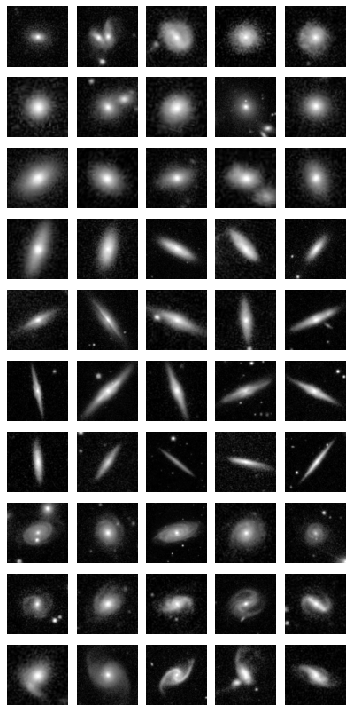

In [81]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(10,5,figsize=(5,10))


for class_i in range(10):
    idxs = np.where( training_ds.labels == class_i )[0]
    idxs = np.random.permutation(idxs)
    for plot_i in range(np.min([5,len(idxs)])):

        ax[class_i][plot_i].imshow(training_ds[idxs[plot_i]][0].reshape(69,69),cmap='gray')
        ax[class_i][plot_i].set_axis_off()
        
plt.tight_layout()
plt.show()

# Now lets build the neural network

its a classifier - it takes as input 69*69 numbers, and outputs 10 numbers

In [37]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        #self.layer1 = #....
        
        self.n_in  = 69*69#n_in
        self.n_out = 10#n_out
        self.n_hidden = 69*69#n_hidden
         
        self.linear = nn.Sequential(
            nn.Linear(self.n_in, self.n_hidden),
            nn.Linear(self.n_hidden ,self.n_hidden),   # Hidden layer.
            nn.Dropout(p=0.2),
            nn.Linear(self.n_hidden ,self.n_out),
            nn.BatchNorm1d(self.n_out),
            nn.ReLU()
            )
        self.logprob = nn.LogSoftmax(dim=1)                 # -Log(Softmax probability).
        
        
        
#     def forward(self,x):
#         # flatten image input
#         x = x.view(-1,28*28)
#         # add hidden layer, with relu activation function
#         x = F.relu(self.fc1(x))
#         # add dropout layer
#         x = self.droput(x)
#          # add hidden layer, with relu activation function
#         x = F.relu(self.fc2(x))

#         x = F.relu(self.fc4(x))
#         # add dropout layer
#         x = self.droput(x)
#         # add output layer
#         x = self.fc3(x)
#         return x
        
    
    def forward(self,x):
        x = self.linear(x)
        #x = self.logprob(x)

        return x

In [38]:
## create the instance

net = Net()

In [39]:
if torch.cuda.is_available():
    net.cuda()

In [40]:
loss_func = nn.CrossEntropyLoss()

## We want to create a function that will compute the loss and accuracy at the end of each epoch

since this is a small dataset, we don't have a memory constraint and its easy to evaluate on the whole dataset at once

In [34]:
tranining_tensor = torch.stack([training_ds[i][0] for i in range(len(training_ds)) ])
training_labels = training_ds.labels.data.numpy()

validation_tensor = torch.stack([validation_ds[i][0] for i in range(len(validation_ds)) ])
validation_labels = validation_ds.labels.data.numpy()

In [92]:
len(torch.LongTensor(training_labels))

10000

accuracy is defined as the number of correctly classifier samples out of the whole dataset

In [41]:
def dataset_accuracy(tensor_dataset,targets,net,loss_func):

    net.eval()

    output = net(tensor_dataset)
    
    loss = loss_func(output,torch.LongTensor(targets))

    output = output.cpu().data.numpy()
    prediction = np.argmax(output,axis=1)

    n_correct = len(np.where(targets==prediction)[0])
    n_total = len(targets)

    return n_correct/n_total, loss.item()

In [42]:
dataset_accuracy(tranining_tensor,training_labels, net, loss_func)

(0.1336, 2.323671579360962)

In [43]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01) 

In [99]:
from tqdm.notebook import tqdm

n_epochs = 50


loss_vs_epoch = []
accuracy_vs_epoch = []

for epoch in tqdm( range(n_epochs) ):
    # monitor losses
    train_loss = 0
    valid_loss = 0
    
    ###################
    # train the model #
    ###################

    net.train()
    for data,label in training_dataloader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        
        #print(output,label)
        # calculate the loss
        loss = loss_func(output,torch.LongTensor(label))
        #stop
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
        
    print(train_loss)
#     output = output.cpu().data.numpy()
#     prediction = np.argmax(output,axis=1)

#     n_correct = len(np.where(targets==prediction)[0])
#     n_total = len(targets)

#     return n_correct/n_total, loss.item()                         
        
    
    ######################    
    # validate the model #
    ######################
    
    net.eval()
    for data,label in valid_dataloader:

        if torch.cuda.is_available():
            data, label = data.cuda(), label.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the loss
        loss = loss_func(output,torch.LongTensor(label))
        # update running validation loss 
        valid_loss += loss.item() * data.size(0)
        
    ######################    
    #     Statistics     #
    ######################
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(training_dataloader.sampler)
    valid_loss = valid_loss / len(valid_dataloader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
#     if valid_loss <= valid_loss_min:
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
#         valid_loss_min,
#         valid_loss))
#         torch.save(model.state_dict(), 'HW1_model.pt')
#         valid_loss_min = valid_loss                         
        
        
    loss_vs_epoch.append([train_loss, valid_loss])
                         
                         
#     output = output.cpu().data.numpy()
#     prediction = np.argmax(output,axis=1)

#     n_correct = len(np.where(targets==prediction)[0])
#     n_total = len(targets)

#     return n_correct/n_total, loss.item()                         
    
#     accuracy_vs_epoch.append([training_accuracy, validation_accuracy])                     
    


21927.615423202515
Epoch: 1 	Training Loss: 2.192762 	Validation Loss: 2.164034
21577.043018341064
Epoch: 2 	Training Loss: 2.157704 	Validation Loss: 2.142784
21264.397478103638
Epoch: 3 	Training Loss: 2.126440 	Validation Loss: 2.124176
20973.509950637817
Epoch: 4 	Training Loss: 2.097351 	Validation Loss: 2.108894
20713.621582984924
Epoch: 5 	Training Loss: 2.071362 	Validation Loss: 2.089671
20478.536620140076
Epoch: 6 	Training Loss: 2.047854 	Validation Loss: 2.108717



KeyboardInterrupt: 

In [96]:
output.shape

torch.Size([120, 10])

In [97]:
loss

tensor(2.1944, grad_fn=<NllLossBackward>)

In [37]:
loss_vs_epoch = np.array(loss_vs_epoch)

plt.plot(loss_vs_epoch[:,0][1:],label='training loss')
plt.plot(loss_vs_epoch[:,1][1:],label='validation loss')

plt.legend()

In [38]:
accuracy_vs_epoch = np.array(accuracy_vs_epoch)

plt.plot(accuracy_vs_epoch[:,0][1:],label='training accuracy')
plt.plot(accuracy_vs_epoch[:,1][1:],label='validation accuracy')

plt.legend()

## save your model

In [43]:
torch.save(net.state_dict(), 'model.pt')

## Bonus round: data augmentation

implement this random rotation into your dataset object - but add an optional input argument to your dataset __init__ so that you can turn this on/off (only use data augmentation for the training dataset)

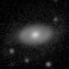

In [72]:
Image.open(filelist[1242])

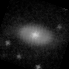

In [73]:
transforms.RandomRotation(180)( Image.open(filelist[1242]) )